In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import wbgapi as wb
import gzip

from urllib.request import urlopen
from urllib.parse import urlencode
from xmltodict import parse
from collections import Counter
from zipfile import ZipFile
from io import BytesIO
from sklearn.metrics import mutual_info_score
from scipy.stats import ttest_rel, chisquare
from scipy.special import rel_entr, kl_div
from datetime import datetime as parse
from mpl_toolkits.basemap import Basemap

# Open Data and Data APIs

Large part of doing data science is working with data: cleaning, understanding, filtering, and tranforming it. But in order to do that we need data. Unless you collect your own data, you will need to find interesting data sets that you can understand and ask questions about. Today, we are going to look at possible data sources and their uses.

An [application programming interface (API)](https://en.wikipedia.org/wiki/API) is a data connection between two pieces of software. For our purposes, it is a connection between a data consumer (you) and data provider.  Its primary function is **not** to provide data for human consumption, rather it is for exchanging data between two computer programs. In short, you'll use an API to fetch the data not to look at it in its raw form.


## Toy Datasets for Teaching and Experimenting

Sometimes, one needs data to learn a topic, make small experiments before embarking on *real* large datasets. For that there is one specific place: [UCI's data repository](https://archive.ics.uci.edu/ml/datasets.php).

Here are a couple of examples:

## Mammographic Masses

[Data](https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/) is about mammography test results on breast tumors.  It is of columnar format (CSV) and contains 7 columns:

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)

The remaining column indicate whether the tumor is benign (encoded as 0) or malignant (encoded as 1).

In [2]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data', header=None)    
data.columns = ['assessment','age','shape','margin','density','type']
data

,assessment,age,shape,margin,density,type
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


In [3]:
Counter(data['type'])

Counter({1: 445, 0: 516})

(array([206., 209., 139., 146.,  99.,  78.,  59.,  25.]),
 array([ 0.   ,  9.125, 18.25 , 27.375, 36.5  , 45.625, 54.75 , 63.875,
        73.   ]),
 <BarContainer object of 8 artists>)

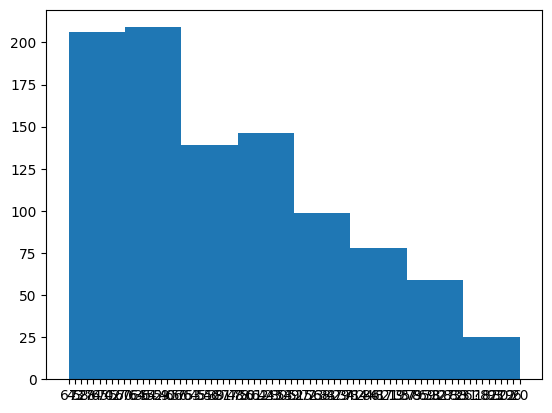

In [4]:
plt.hist(data['age'],8)

In [5]:
res = pd.crosstab(data['shape'],data['type'])
pdf = res/res.sum()
pdf

type,0,1
shape,,
1,0.360465,0.085393
2,0.341085,0.078652
3,0.096899,0.101124
4,0.164729,0.707865
?,0.036822,0.026966


In [6]:
rel_entr(pdf.iloc[:,0],pdf.iloc[:,1]).sum()

0.7866915524379823

## Bank Marketing Data Set

[The data](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) is about marketing campaigns of a Portuguese bank. The marketing campaigns were done via phone. Data again is of columnar format. It contains 21 columns:

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4.  education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5.  default: has credit in default? (categorical: 'no','yes','unknown')
6.  housing: has housing loan? (categorical: 'no','yes','unknown')
7.  loan: has personal loan? (categorical: 'no','yes','unknown')
8.  contact: contact communication type (categorical: 'cellular','telephone')
9.  month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10.  day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11.  duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12.  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13.  pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14.  previous: number of contacts performed before this campaign and for this client (numeric)
15.  poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
16.  emp.var.rate: employment variation rate.  quarterly indicator (numeric)
17.  cons.price.idx: consumer price index.  monthly indicator (numeric)
18.  cons.conf.idx: consumer confidence index.  monthly indicator (numeric)
19.  euribor3m: euribor 3 month rate.  daily indicator (numeric)
20.  nr.employed: number of employees.  quarterly indicator (numeric)


The remaining column is indicates whether the customer bought the banking service that was advertised/marketed.

In [7]:
with urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip') as url:
    zf = ZipFile(BytesIO(url.read()))
    data = pd.read_csv(zf.open('bank.csv'),sep=';')
    
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [8]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [9]:
Counter(data['y'])

Counter({'no': 4000, 'yes': 521})

In [10]:
tabl = pd.crosstab(data['education'],data['default'])
tabl

default,no,yes
education,,
primary,668,10
secondary,2260,46
tertiary,1333,17
unknown,184,3


In [11]:
pdf = tabl/tabl.sum(axis=0)
pdf

default,no,yes
education,,
primary,0.150281,0.131579
secondary,0.508436,0.605263
tertiary,0.299888,0.223684
unknown,0.041395,0.039474


In [12]:
rel_entr(pdf.iloc[:,0],pdf.iloc[:,1]).sum()

0.021226165052705318

## Data Science Competitions and Hackathons

[Kaggle](https://kaggle.com) is a data science community page that serves those people who take data challenges as a competition. There are varieties of data science competitions that you can browse, try and even start working on to compete. However, the datasets are not open. This means, you must first register to kaggle before you can look into data and you can download data using their webpage or their specific client. The code below works only if you already are registered and put `kaggle.json` authentication key to your home directory.

In [13]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

api.dataset_list()

[akshaydattatraykhare/diabetes-dataset,
 whenamancodes/covid-19-coronavirus-pandemic-dataset,
 evangower/premier-league-matches-19922022,
 whenamancodes/student-performance,
 adnananam/spotify-artist-stats,
 narayan63/netflix-popular-movies-dataset,
 whenamancodes/students-performance-in-exams,
 iamsouravbanerjee/world-population-dataset,
 pantanjali/unemployment-dataset,
 whenamancodes/alcohol-effects-on-study,
 whenamancodes/hr-employee-attrition,
 whenamancodes/tesla-inc-stock-market-analysis-founding-years,
 arslanali4343/covid19-data-from-world,
 anushabellam/trending-videos-on-youtube,
 sergylog/ab-test-data,
 sanjeetsinghnaik/fifa-23-players-dataset,
 madhurpant/world-economic-data,
 thedevastator/airplane-crashes-and-fatalities,
 dansbecker/melbourne-housing-snapshot,
 guerl1/fifa-23-complete-player-database]

In [14]:
api.dataset_download_files('anushabellam/trending-videos-on-youtube', 
                           path='./data')
zip = ZipFile('./data/trending-videos-on-youtube.zip')
zip.filelist

[<ZipInfo filename='Trending videos on youtube dataset.csv' compress_type=deflate file_size=72732 compress_size=29506>]

In [15]:
data = pd.read_csv(zip.open('Trending videos on youtube dataset.csv'))
zip.close()
data

,Unnamed: 0,channelId,channelTitle,videoId,publishedAt,videoTitle,videoDescription,videoCategoryId,videoCategoryLabel,duration,durationSec,definition,caption,viewCount,likeCount,dislikeCount,commentCount
0,0,UCU1_l0ZJyTK_7HZZ3Ruw8Dg,MAPS,pTnk3ziVVRM,2014-01-10T01:24:57.000Z,Psychedelic Horizons Beyond Psychotherapy Work...,Watch the full workshop at http://psychedelics...,29,Nonprofits & Activism,PT1H19M40S,4780,hd,False,1512,8.0,0.0,1.0
1,1,UCLuO2lUqHrPIIpx0hFenV2g,Tink Tink Club,cuJjSeHZIrg,2015-06-18T16:56:04.000Z,Episode 35 - Dr. James Fadiman,Dr. James Fadiman is the father of modern psyc...,22,People & Blogs,PT1H12M34S,4354,sd,False,881,14.0,0.0,3.0
2,2,UCihqrkaOgVMfLNo2W1hSliA,Podcast Bunk,IuyuZfWtGgg,2016-05-01T05:33:13.000Z,#325 Microdosing from The Adam and Dr Drew Sho...,Adam and Dr. Drew are solo today and they open...,22,People & Blogs,PT50M40S,3040,sd,False,67,0.0,1.0,3.0
3,3,UCgbWWPn3VYYzxjffZbfj9GQ,Alan Springwind,cng_ZhQf8iY,2016-01-25T04:48:22.000Z,Microdosing Away The Same Old Blues,Source: https://www.spreaker.com/user/springwi...,24,Entertainment,PT32M21S,1941,hd,False,4,0.0,0.0,0.0
4,4,UCFmLi6X1mojkFZOFngNR9tQ,Drug Education Agency,OpQIQEx7J5A,2014-08-15T10:53:58.000Z,Erschossener Kiffer / Drogen in Mikro-Dosierun...,"Von erschossenen ""Dealern"", von demonstrierend...",24,Entertainment,PT26M32S,1592,hd,False,5465,121.0,6.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,110,UCjnXuO6mfE0-czvcbOYnpbQ,Ayahuasca Magic,j9HFlDff2XY,2016-03-25T04:58:34.000Z,Time differentials: mystery wisdom and microdo...,The lectures I talk about are free (some of th...,24,Entertainment,PT26M,26,hd,False,304,6.0,0.0,22.0
111,111,UC0dsjSDsLZ5hbmoNjvsHJsQ,fluidresearch,lOGAkCtT4wk,2010-08-20T14:46:56.000Z,Fluid filling with exact precision dosing by F...,See how the industry leaders in Precision micr...,26,Howto & Style,PT18S,18,sd,False,294,0.0,0.0,0.0
112,112,UCmNZB3-zCyMuHCOTraws0dg,Helix Steel Victoria,sTNaGjt6564,2014-05-19T12:14:36.000Z,Accurate dosing of Helix Twisted Steel Micro R...,© Copyright --- Look at the steady rain of Hel...,28,Science & Technology,PT11S,11,hd,False,463,0.0,0.0,0.0
113,113,UC281yIVp-U8Ijg4KUVRgDRA,Osiron X,fMlQoGINGHo,2016-04-15T19:31:48.000Z,Psilocybin Mushroom Micro-Dosing,"When too much time lapses between trips, the e...",24,Entertainment,PT11M,11,sd,False,341,11.0,1.0,10.0


In [16]:
api.dataset_download_files('kamilpytlak/personal-key-indicators-of-heart-disease', 
                           path='./data')
zip = ZipFile('./data/personal-key-indicators-of-heart-disease.zip')
zip.filelist

[<ZipInfo filename='heart_2020_cleaned.csv' compress_type=deflate file_size=25189554 compress_size=3277488>]

In [17]:
data = pd.read_csv(zip.open('heart_2020_cleaned.csv'))
zip.close()
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [18]:
pdf = pd.crosstab(data['GenHealth'],data['Sex'])
pdf = pdf/pdf.sum(axis=0)
pdf

Sex,Female,Male
GenHealth,,
Excellent,0.200596,0.218310
Fair,0.115080,0.101099
Good,0.289640,0.292953
Poor,0.037174,0.033232
Very good,0.357510,0.354405


In [19]:
chisquare(pdf,axis=None)

Power_divergenceResult(statistic=0.684890753517329, pvalue=0.9998836633461725)

In [20]:
api.competition_download_files('titanic', path='./data')
zip = ZipFile('titanic.zip')
zip.filelist

[<ZipInfo filename='gender_submission.csv' compress_type=deflate file_size=3258 compress_size=872>,
 <ZipInfo filename='test.csv' compress_type=deflate file_size=28629 compress_size=11171>,
 <ZipInfo filename='train.csv' compress_type=deflate file_size=61194 compress_size=22388>]

In [21]:
data = pd.read_csv(zip.open('train.csv'))
zip.close()
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [22]:
surv = pd.crosstab(data['Survived'],data['Sex'])
pdf = surv/surv.sum()
pdf

Sex,female,male
Survived,,
0,0.257962,0.811092
1,0.742038,0.188908


# Data From Municipalities

We have used [data from Istanbul Municipality data service](https://data.ibb.gov.tr/). There are other municipalties that serves open data:

1. [Istanbul Municipality](https://data.ibb.gov.tr/)
2. [Izmir Municipality](https://acikveri.bizizmir.com/)
3. [Bursa Municipality](https://acikyesil.bursa.bel.tr/dataset/)
4. [Athens Open Data](http://geodata.gov.gr/en/dataset)
4. [Barcelona Municipality](https://opendata-ajuntament.barcelona.cat/)
5. [London Data Store](https://data.london.gov.uk/developers/)
6. [New York Open Data](https://opendata.cityofnewyork.us/)
7. [City of Montreal Open Data](https://donnees.montreal.ca/collections)
8. [City of Toronto Open Data](https://open.toronto.ca/)

Best way to explore is search "open data api" + your favorite city :) 


Here is the graph of mean natural gas consumption in Istanbul in (numbers are in 10 mil m3) per year


In [23]:
data = pd.read_csv('https://data.ibb.gov.tr/dataset/78ef6c0c-3fd0-45bd-812d-7232384a3b6d/resource/762b802e-c5f9-4175-a5c1-78b892d9764b/download/ibb-yags-verileri-2011-21.csv',
                   encoding='iso8859-9',
                   sep=';', 
                   thousands='.',
                   decimal=',',
                   parse_dates = ['Tarih'],
                   date_parser = lambda date: parse.strptime(date, '%d.%m.%Y'))
data

,Tarih,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere
0,2011-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
1,2011-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2,2011-01-03,0.00,0.00,0.00,0.42,1.37,0.87,0.2,2.26,1.89
3,2011-01-04,8.08,10.01,11.64,18.82,9.64,14.72,13.5,8.20,10.37
4,2011-01-05,2.78,8.48,7.09,3.42,0.83,4.31,4.3,1.44,1.60
...,...,...,...,...,...,...,...,...,...,...
3718,2021-03-07,10.93,13.44,11.33,17.80,14.40,6.50,10.4,23.40,20.86
3719,2021-03-08,0.33,0.00,0.00,0.00,0.20,0.00,0.4,0.00,0.00
3720,2021-03-09,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
3721,2021-03-10,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [24]:
data['Yıl'] = pd.DatetimeIndex(data['Tarih']).year
data['Ay'] = pd.DatetimeIndex(data['Tarih']).month
data['Gün'] = pd.DatetimeIndex(data['Tarih']).day
data

,Tarih,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere,Yıl,Ay,Gün
0,2011-01-01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2011,1,1
1,2011-01-02,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2011,1,2
2,2011-01-03,0.00,0.00,0.00,0.42,1.37,0.87,0.2,2.26,1.89,2011,1,3
3,2011-01-04,8.08,10.01,11.64,18.82,9.64,14.72,13.5,8.20,10.37,2011,1,4
4,2011-01-05,2.78,8.48,7.09,3.42,0.83,4.31,4.3,1.44,1.60,2011,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3718,2021-03-07,10.93,13.44,11.33,17.80,14.40,6.50,10.4,23.40,20.86,2021,3,7
3719,2021-03-08,0.33,0.00,0.00,0.00,0.20,0.00,0.4,0.00,0.00,2021,3,8
3720,2021-03-09,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2021,3,9
3721,2021-03-10,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2021,3,10


In [25]:
toplam = data[['Yıl','Ömerli','Darlik', 'Elmali', 'Terkos', 'B.çekmece', 'Sazlidere', 'Alibey', 'Kazandere', 'Pabuçdere']].groupby('Yıl').sum()
toplam

,Ömerli,Darlik,Elmali,Terkos,B.çekmece,Sazlidere,Alibey,Kazandere,Pabuçdere
Yıl,,,,,,,,,
2011,450.95,487.43,500.62,764.17,429.46,499.59,527.07,988.25,1095.06
2012,799.44,990.00,758.09,863.47,618.79,576.75,852.19,1046.55,1048.16
2013,436.51,556.56,430.61,701.69,445.87,445.24,496.72,709.73,777.00
2014,795.35,847.78,620.82,1253.16,586.00,796.73,919.38,1328.81,1339.93
2015,824.41,926.99,789.99,791.40,579.09,610.58,716.08,936.86,805.68
2016,798.29,946.75,765.06,748.55,519.37,665.86,803.45,998.72,807.43
2017,721.40,828.29,720.76,910.11,644.99,612.90,797.94,1357.73,1099.76
2018,842.04,814.45,546.32,1042.66,767.87,866.87,723.46,1025.59,858.58
2019,583.29,646.96,415.37,586.90,447.24,482.90,573.80,604.84,584.77


<BarContainer object of 11 artists>

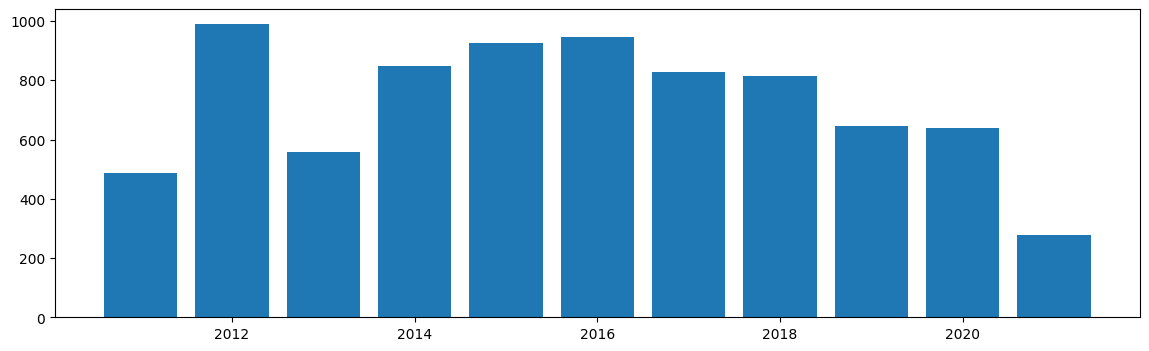

In [26]:
plt.figure(figsize=(14,4))
plt.bar(height=toplam.iloc[:,1],
         x = toplam.index)

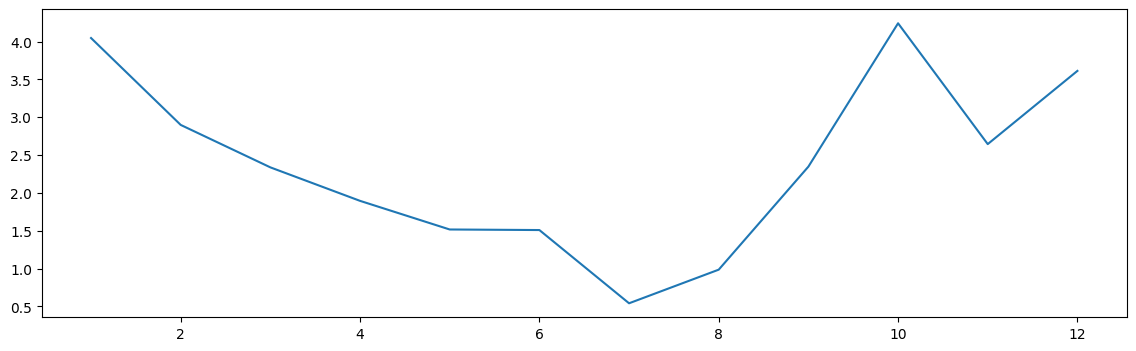

In [27]:
plt.figure(figsize=(14,4))
plt.plot(data[['Ay','Terkos']].groupby('Ay').mean())

# Data from Government Organizations

1. [European Central Bank](https://sdw.ecb.europa.eu/)
2. [OECD data](https://data.oecd.org/)
3. [The US Central Bank (FED) data](https://fred.stlouisfed.org/)
4. [The World Bank Data](https://data.worldbank.org/)
5. [The US Goverment](https://data.gov/developers/apis/index.html) collected all of its open data sources under a single service.
6. [Indian Government Data Portal](https://data.gov.in/)
7. [European Union Data Portal](https://data.europa.eu/en)
8. [Turkish Supreme Election Council](https://acikveri.ysk.gov.tr/anasayfa) (Yüksek Seçim Kurulu) also publishes critical data on all Turkish elections on their data service.
9. [International Monetary Fund (IMF) Data Portal](https://www.imf.org/en/Data)


## WorldBank Data API

In [28]:
popl = pd.DataFrame(wb.data.fetch('SP.POP.TOTL'))
popl

,value,series,economy,aggregate,time
0,15092171.0,SP.POP.TOTL,ZWE,False,YR2021
1,14862927.0,SP.POP.TOTL,ZWE,False,YR2020
2,14645473.0,SP.POP.TOTL,ZWE,False,YR2019
3,14438812.0,SP.POP.TOTL,ZWE,False,YR2018
4,14236599.0,SP.POP.TOTL,ZWE,False,YR2017
...,...,...,...,...,...
16487,144920186.0,SP.POP.TOTL,AFE,True,YR1964
16488,141202036.0,SP.POP.TOTL,AFE,True,YR1963
16489,137614644.0,SP.POP.TOTL,AFE,True,YR1962
16490,134159786.0,SP.POP.TOTL,AFE,True,YR1961


In [29]:
tmp = popl[popl['economy']=='TUR'][['value','time']]
tmp.sort_values(by='time', inplace=True)
tmp.index = tmp['time']
tmp

,value,time
time,,
YR1960,27472339.0,YR1960
YR1961,28146909.0,YR1961
YR1962,28832831.0,YR1962
YR1963,29531362.0,YR1963
YR1964,30244258.0,YR1964
...,...,...
YR2017,81116451.0,YR2017
YR2018,82340090.0,YR2018
YR2019,83429607.0,YR2019


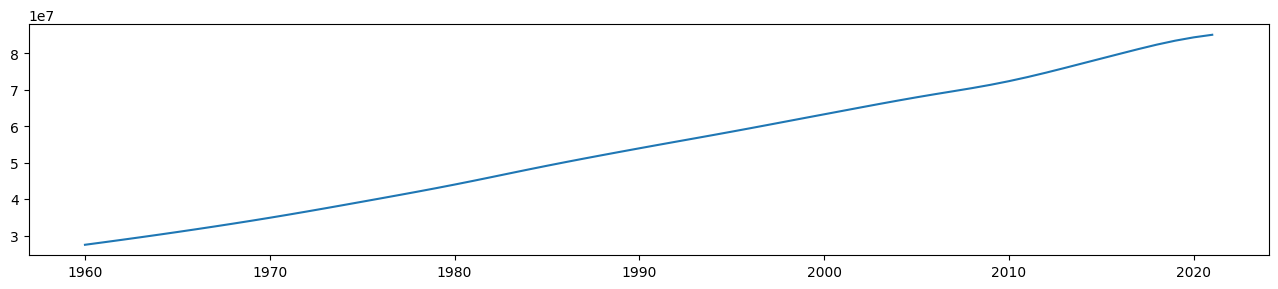

In [30]:
plt.figure(figsize=(16,3))
plt.plot(range(1960,2022),tmp['value'])

In [31]:
journals = pd.DataFrame(wb.data.fetch('IP.JRN.ARTC.SC'))
journals.sort_values(by='value',inplace=True)
journals

,value,series,economy,aggregate,time
2369,0.0,IP.JRN.ARTC.SC,SSD,False,YR2008
7087,0.0,IP.JRN.ARTC.SC,KIR,False,YR2002
7089,0.0,IP.JRN.ARTC.SC,KIR,False,YR2000
4902,0.0,IP.JRN.ARTC.SC,NRU,False,YR2017
4909,0.0,IP.JRN.ARTC.SC,NRU,False,YR2010
...,...,...,...,...,...
16487,NaN,IP.JRN.ARTC.SC,AFE,True,YR1964
16488,NaN,IP.JRN.ARTC.SC,AFE,True,YR1963
16489,NaN,IP.JRN.ARTC.SC,AFE,True,YR1962
16490,NaN,IP.JRN.ARTC.SC,AFE,True,YR1961


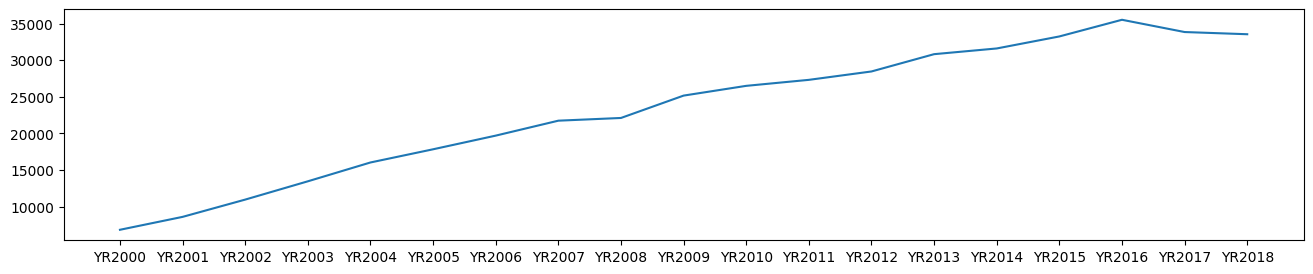

In [32]:
tmp = journals[journals['economy']=='TUR'][['value','time']].dropna()
tmp.sort_values(by='time',inplace=True)
tmp.index = tmp['time']

plt.figure(figsize=(16,3))
plt.plot(tmp['value'])

## OECD Data API

In [33]:
def getOECD(dataset,start,end):
    params = {
        'contentType': 'csv',
        'separator': 'comma',
        'startPeriod': start,
        'endPeriod': end    
    }
    url = f'https://stats.oecd.org/sdmx-json/data/DP_LIVE/{dataset}/OECD?{urlencode(params)}'
    return pd.read_csv(url)   

electricity = getOECD('.ELECTRICITY.TOT.GWH.A',1990,2022)
electricity

,LOCATION,Country,INDICATOR,Indicator,SUBJECT,Subject,MEASURE,Measure,FREQUENCY,Frequency,TIME,Time,Value,Flag Codes,Flags
0,AUS,Australia,ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,1990,1990,144926.000,NaN,NaN
1,AUS,Australia,ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,1991,1991,147121.000,NaN,NaN
2,AUS,Australia,ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,1992,1992,149306.000,NaN,NaN
3,AUS,Australia,ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,1993,1993,153420.000,NaN,NaN
4,AUS,Australia,ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,1994,1994,157232.000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,EU27_2020,European Union – 27 countries (from 01/02/2020),ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,2017,2017,2814920.542,NaN,NaN
1756,EU27_2020,European Union – 27 countries (from 01/02/2020),ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,2018,2018,2802323.762,NaN,NaN
1757,EU27_2020,European Union – 27 countries (from 01/02/2020),ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,2019,2019,2776012.131,NaN,NaN
1758,EU27_2020,European Union – 27 countries (from 01/02/2020),ELECTRICITY,Electricity generation,TOT,Total,GWH,Gigawatt-hours,A,Annual,2020,2020,2664236.011,NaN,NaN


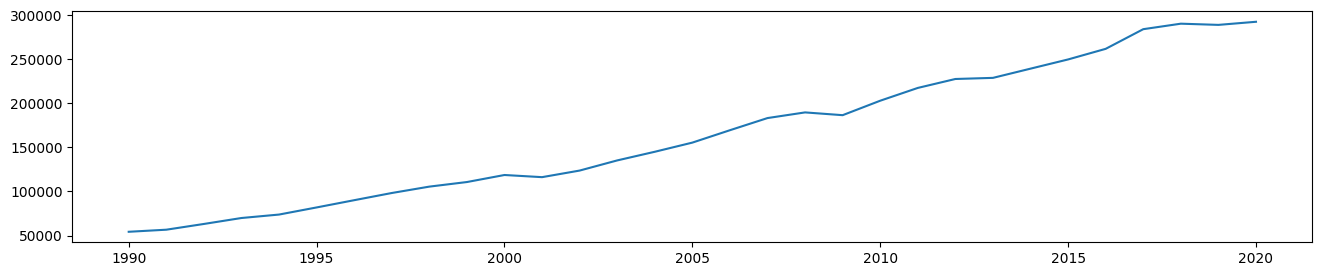

In [34]:
tmp = electricity[electricity['LOCATION']=='TUR'][['Time','Value']]
tmp.index = tmp.Time

plt.figure(figsize=(16,3))
plt.plot(tmp.Value)

In [35]:
accidents = getOECD('.ROADACCID.DEATH.1000000HAB.A',start=1970,end=2022)
accidents

,LOCATION,Country,INDICATOR,Indicator,SUBJECT,Subject,MEASURE,Measure,FREQUENCY,Frequency,TIME,Time,Value,Flag Codes,Flags
0,LUX,Luxembourg,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,1994,1994,163.802196,NaN,NaN
1,LUX,Luxembourg,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,1995,1995,171.306210,NaN,NaN
2,LUX,Luxembourg,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,1996,1996,171.404430,NaN,NaN
3,LUX,Luxembourg,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,1997,1997,143.044463,NaN,NaN
4,LUX,Luxembourg,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,1998,1998,134.212385,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,KAZ,Kazakhstan,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,2016,2016,134.314522,NaN,NaN
1364,KAZ,Kazakhstan,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,2017,2017,115.646186,NaN,NaN
1365,KAZ,Kazakhstan,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,2018,2018,114.683091,NaN,NaN
1366,KAZ,Kazakhstan,ROADACCID,Road accidents,DEATH,Deaths,1000000HAB,Per 1 000 000 inhabitants,A,Annual,2019,2019,105.165517,NaN,NaN


In [36]:
np.unique(accidents['LOCATION'])

array(['ALB', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BGR', 'BIH',
       'BLR', 'CAN', 'CHE', 'CHL', 'CZE', 'DEU', 'DNK', 'ESP', 'EST',
       'FIN', 'FRA', 'GBR', 'GEO', 'GRC', 'HRV', 'HUN', 'IND', 'IRL',
       'ISL', 'ISR', 'ITA', 'JPN', 'KAZ', 'KOR', 'LTU', 'LUX', 'LVA',
       'MAR', 'MDA', 'MKD', 'MLT', 'MNE', 'NLD', 'NOR', 'NZL', 'POL',
       'PRT', 'ROU', 'RUS', 'SRB', 'SVK', 'SVN', 'SWE', 'TUR', 'UKR',
       'USA'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


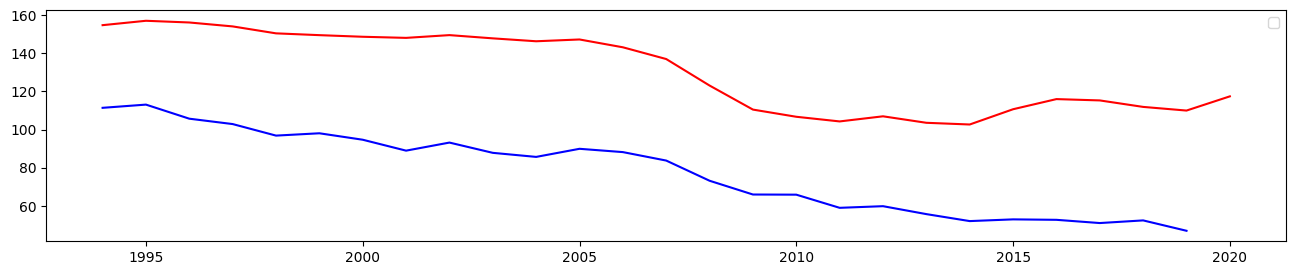

In [37]:
us = accidents[accidents['LOCATION']=='USA'][['Value','Time']]
us.index = us.Time
can = accidents[accidents['LOCATION']=='CAN'][['Value','Time']]
can.index = can.Time

plt.figure(figsize=(16,3))
plt.plot(us.Value, c='red')
plt.plot(can.Value, c='blue')
plt.legend()


# Geological Survey Data

## US Geological Survey 

[USGS](https://www.usgs.gov/products) has a very large data store where you can get variety of scientific data that included Earthquakes, Satellite images, Maps, and much much more.

## European Space Agency

[European Space Agency](https://open.esa.int/) has an excellent open data service from which you can access a variety of data products such as maps, satellite images and more.

## NASA 

[NASA](https://data.nasa.gov/) also has an open data service.


### An Example from NASA

####  Global Landslide Catalog Export

> The Global Landslide Catalog (GLC) was developed with the goal of identifying rainfall-triggered landslide events 
> around the world, regardless of size, impacts or location. The GLC considers all types of mass movements triggered 
> by rainfall, which have been reported in the media, disaster databases, scientific reports, or other sources. The 
> GLC has been compiled since 2007 at NASA Goddard Space Flight Center. This is a unique data set with the ID tag 
> “GLC” in the landslide editor.

In [38]:
landslides = pd.read_csv('https://data.nasa.gov/api/views/dd9e-wu2v/rows.csv?accessType=DOWNLOAD')
    
landslidesTR = landslides[landslides['country_code'] == 'TR']
landslidesTR[['event_date','admin_division_name','gazeteer_closest_point','longitude','latitude']]

,event_date,admin_division_name,gazeteer_closest_point,longitude,latitude
971,09/23/2009 08:00:00 PM,Artvin,Borçka,41.6822,41.3639
1155,07/16/2013 08:00:00 AM,Hatay,Hassa,36.4354,36.7619
1224,08/24/2015 12:00:00 AM,Artvin,Hopa,41.4323,41.3936
2030,09/09/2008 12:00:00 AM,Siirt,Gözpınar,41.5061,37.9472
2319,07/07/2016 11:00:00 PM,Trabzon,Dağbaşı,39.9081,40.8167
2608,09/09/2009 12:00:00 AM,Istanbul,Eminönü,28.9759,41.0124
2700,03/07/2013 12:00:00 AM,Hakkâri,Çukurca,43.6143,37.2506
2780,11/21/2009 12:00:00 AM,Trabzon,Trabzon,39.7365,40.9792
2958,01/27/2013 12:00:00 AM,Diyarbakır,Diyarbakır,40.2306,37.9152
3406,09/28/2008 12:00:00 AM,Sakarya,Karapürçek,30.4580,40.6900


### An Example from USGS

Paleohydrologic reconstructions of water-year streamflow for 31 stream gaging sites in the Missouri River Basin with complete data for 1685 through 1977

In [39]:
paleohydro = pd.read_csv('https://www.sciencebase.gov/catalog/file/get/5c994278e4b0b8a7f628903e?f=__disk__3d%2F8b%2F51%2F3d8b512c0dec73102f0c8d7b5c3e8d326dce54fa')    
paleohydro

,Latitude,Longitude,Gage or Reconstruction Name,USGS Gage ID,Year(row) /Id(col),1685,1686,1687,1688,1689,...,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977
0,45.116127,-112.75050,"Beaverhead River at Barretts, Montana",6016000,R1,444.433230,363.587220,794.49506,981.97470,658.24810,...,622.38715,600.00226,572.79840,728.22174,644.83290,591.26510,622.86070,612.43160,711.77300,425.95398
1,45.506912,-112.33089,"Ruby River near Twin Bridges, Montana",6023000,R2,219.264920,141.933170,245.13747,380.43802,185.72981,...,262.86417,316.82214,446.59970,305.67680,296.20413,241.70609,317.83478,381.02002,276.68330,232.38223
2,45.526581,-112.70172,"Big Hole River near Melrose, Montana",6025500,R3,1457.464000,1213.416700,1228.75370,932.24786,1080.46250,...,1378.20530,1602.58730,1269.83020,1799.21060,1339.16440,1042.20080,1608.72840,1624.03110,1836.77510,615.80316
3,45.897137,-111.59567,"Jefferson River near Three Forks, Montana",6036650,R4,2910.249800,2095.854500,3038.66970,3656.89580,2312.44870,...,3400.91630,3679.21660,3243.61080,3477.68460,2926.19140,2609.25900,3207.65870,3195.48750,3847.85770,2306.35380
4,45.490231,-111.63451,Madison River below Ennis Lake near McAllister...,6041000,R5,1215.694700,1445.360700,1898.49540,1967.13930,1418.36170,...,1961.48440,2027.46800,1646.18950,2304.48170,1867.69890,1773.10990,1891.25320,2068.86040,1942.11870,1431.26810
5,45.823559,-111.49966,"Madison River near Three Forks, Montana",6042500,R6,1529.759400,1630.721600,1848.33040,1986.04640,1639.65450,...,1835.35890,1960.75730,2249.08130,2346.00300,2089.77980,1816.17600,2281.50020,2089.39180,2072.58000,1471.04190
6,45.885357,-111.43829,"Gallatin River at Logan, Montana",6052500,R7,1158.373000,1124.973300,1156.45910,1501.32980,1279.30940,...,1519.12220,1522.14400,1686.82680,1896.32360,1329.28390,1280.63430,1437.24020,1702.78610,1755.73390,946.00340
7,46.146572,-111.42028,"Missouri River at Toston, Montana",6054500,R8,4906.707000,3933.409000,5750.33600,5431.72700,5060.82800,...,6346.73200,7067.96500,6532.60250,6476.41600,6229.90600,6263.93600,7455.65670,7631.82300,7175.91600,4608.80570
8,47.199024,-112.09591,"Dearborn River near Craig, Montana",6073500,R9,120.766320,188.489850,167.77414,112.52711,235.91763,...,169.14919,185.14203,207.92440,171.85780,140.97868,89.46792,172.00705,216.05415,281.65634,106.80695
9,47.190052,-111.38719,"Smith River near Eden, Montana",6077500,R10,296.586060,218.166660,249.01877,546.02515,730.56990,...,534.23740,535.42110,547.50714,377.71198,354.82062,353.42462,431.41824,615.23990,514.08124,272.23850


<AxesSubplot:>

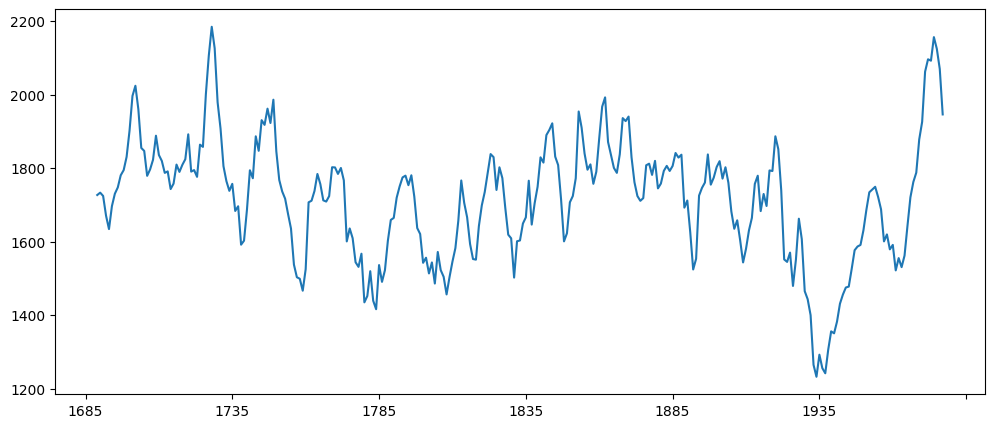

In [40]:
(paleohydro.iloc[5,5:]).rolling(window=5).mean().plot(figsize=(12,5))

In [41]:
def getEarthQuakeData(minlat,maxlat,minlong,maxlong,mag):
    params = {'starttime': '1995-01-01',
              'endtime': '2022-03-01',
              'minlatitude': minlat,
              'maxlatitude': maxlat,
              'minlongitude': minlong,
              'maxlongitude': maxlong,
              'minmagnitude': mag,
              'eventtype': 'earthquake',
              'producttype': 'origin'}
    url = f'https://earthquake.usgs.gov/fdsnws/event/1/query.csv?{urlencode(params)}' 
    return pd.read_csv(url)

In [42]:
tur = getEarthQuakeData(39,43,23,33, 3.5)
tur

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-02-20T20:20:11.665Z,40.7690,27.4040,10.00,4.4,mb,NaN,39.0,1.037,0.65,...,2022-05-04T13:39:02.040Z,"13 km SSW of Kumba?, Turkey",earthquake,2.3,2.0,0.189,8.0,reviewed,us,us
1,2022-02-06T12:07:52.856Z,40.5313,28.9725,11.00,4.2,mb,NaN,56.0,1.223,0.55,...,2022-04-19T17:38:47.040Z,"11 km SSW of Kocadere, Turkey",earthquake,2.2,6.4,0.186,8.0,reviewed,us,us
2,2022-01-22T19:31:42.837Z,39.5763,28.8232,2.68,4.6,mwr,NaN,26.0,0.744,0.69,...,2022-04-09T20:18:50.040Z,"17 km E of Dursunbey, Turkey",earthquake,2.7,4.2,0.060,27.0,reviewed,us,us
3,2022-01-22T02:32:56.485Z,39.5734,24.2602,10.00,4.5,mb,NaN,66.0,1.462,1.36,...,2022-04-09T20:18:47.040Z,"58 km NE of Patitírion, Greece",earthquake,5.2,2.0,0.271,5.0,reviewed,us,us
4,2022-01-16T22:32:01.622Z,40.1249,24.4732,10.00,4.4,mb,NaN,52.0,1.300,0.78,...,2022-04-01T17:40:13.040Z,"24 km SE of Karyes, Greece",earthquake,5.3,1.7,0.149,13.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,1995-01-22T22:27:29.330Z,40.6110,23.4000,10.00,4.0,ml,NaN,NaN,NaN,1.10,...,2014-11-07T00:57:10.483Z,"3 km WSW of Néa Apollonía, Greece",earthquake,NaN,NaN,NaN,NaN,reviewed,us,the
1494,1995-01-18T12:36:34.170Z,40.0170,30.6410,10.00,3.6,md,NaN,NaN,NaN,0.60,...,2014-11-07T00:57:09.419Z,"5 km E of Mihalgazi, Turkey",earthquake,NaN,NaN,NaN,NaN,reviewed,us,isk
1495,1995-01-08T22:29:57.340Z,39.7960,30.5080,10.00,3.7,md,NaN,NaN,NaN,0.90,...,2014-11-07T00:57:06.907Z,"2 km NNW of Eski?ehir, Turkey",earthquake,NaN,NaN,NaN,NaN,reviewed,us,isk
1496,1995-01-08T13:08:54.980Z,39.3290,25.5500,27.00,4.2,mb,NaN,NaN,NaN,0.90,...,2014-11-07T00:57:06.860Z,"37 km WNW of Eresós, Greece",earthquake,NaN,2.3,NaN,18.0,reviewed,us,us


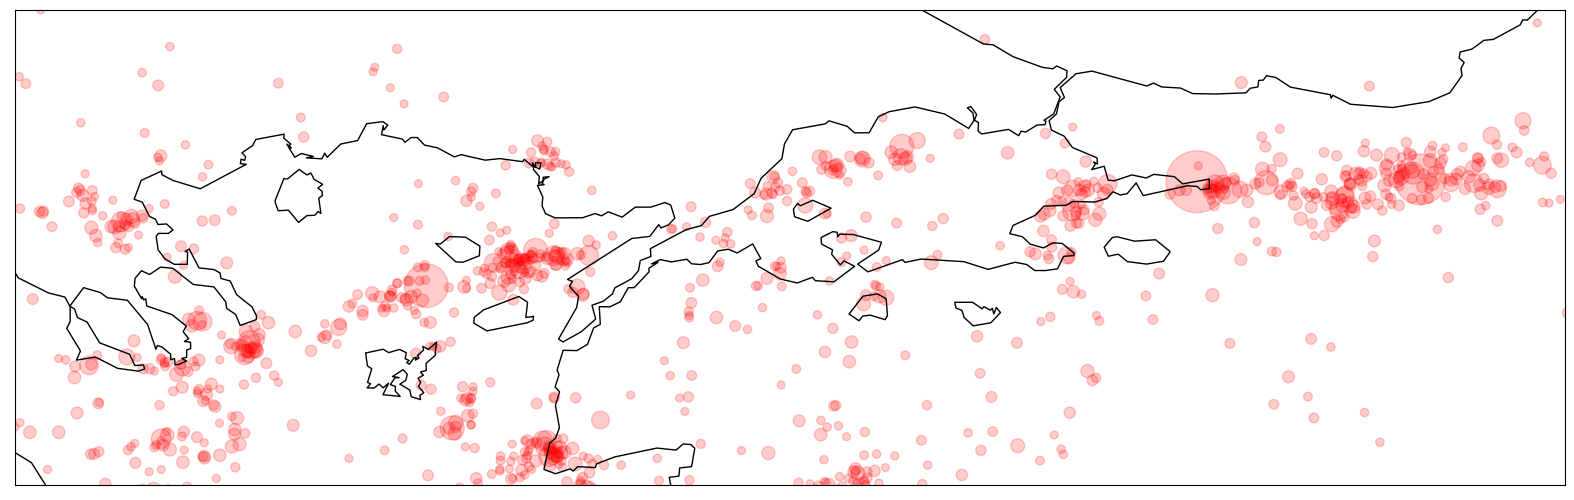

In [43]:
fig = plt.figure(figsize=(20,12))

m = Basemap(projection='merc',
           llcrnrlat = 39.4,
           urcrnrlat = 41.5,
           llcrnrlon = 23,
           urcrnrlon = 32,
           resolution='i')

m.drawcoastlines()

xs,ys = m(tur['longitude'], tur['latitude'])
sizes = np.exp(tur['mag'])

m.scatter(xs, ys, s=sizes, c='red', alpha=0.2)

plt.show()

# Image Classification Data Sets

Here is a small sample of image dataset that can be used for image classification tasks:

1. [MNIST](http://yann.lecun.com/exdb/mnist/) 
2. [Extended MNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset)
3. [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)
4. [Japanese MNIST](https://github.com/rois-codh/kmnist)
5. [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html)
6. [Olivetti faces data set](https://scikit-learn.org/0.19/datasets/olivetti_faces.html)

In [44]:
with urlopen('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz') as url:
    fmnist = np.frombuffer(gzip.open(BytesIO(url.read()),'rb').read(), 
                           dtype=np.uint8,
                           offset=16)

fmnist = fmnist.reshape(10000, 784)

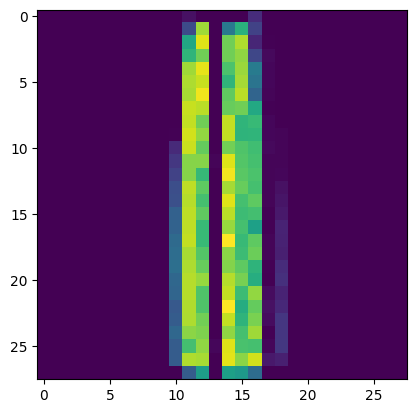

In [45]:
N = np.random.randint(10000)
plt.imshow(fmnist[N].reshape((28,28)))

# Satellite Image Data

1. [Hyperspectral Remote Sensing Scenes](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes)
2. [A large list of open GIS Image data sets](https://freegisdata.rtwilson.com/)

In [3]:
pollution = pd.read_excel('https://www.eea.europa.eu/data-and-maps/data/air-pollutant-concentrations-at-station/air-pollutant-concentrations-2017/air-pollutant-concentrations-2017-compared-1/at_download/file')
pollution

,PM10 measurements at station level in 2017,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WHO air quality guideline for particulate matt...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AirPollutionLevel is the annual mean PM10 conc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2928,Germany,NaN,DEUB044,Zugspitze Schneefernerhaus,PM10,3.719975,ug/m3,Background,rural,10.980657,47.414435999999995,2650
2929,Finland,NaN,FI00356,Sammaltunturi,PM10,2.722191,ug/m3,Background,rural,24.112330000000004,67.96714999962705,566
2930,Sweden,NaN,SE0005R,Bredkälen,PM10,2.714006,ug/m3,Background,rural,15.31973,63.845496999575694,380
2931,Iceland,NaN,IS0039A,Reykjanes Leiran,PM10,2.633037,ug/m3,Industrial,suburban,-22.600490999999998,64.04275699957795,371


In [4]:
cols = pollution.iloc[5,:]
pollution = pollution.iloc[6:,:]
pollution.columns = cols
pollution

5,Country,City,AirQualityStationEoICode,AQStationName,AirPollutant,AirPollutionLevel,UnitOfAirpollutionLevel,AirQualityStationType,AirQualityStationArea,Longitude,Latitude,Altitude
6,Turkey,NaN,TR760141,IGDIR,PM10,114.235046,ug/m3,Background,urban,44.05361,39.9261099994713,859
7,Turkey,NaN,TR460241,KAHRAMANMARAS-ELBISTAN,PM10,99.351826,ug/m3,Background,urban,37.19834,38.203839999477836,1141
8,Turkey,NaN,TR160141,BURSA,PM10,94.415068,ug/m3,Background,urban,29.03806,40.23442999947032,92
9,Turkey,NaN,TR060641,ANKARA-KAYAS,PM10,92.578767,ug/m3,Background,urban,32.92676,39.925379999471296,922
10,Turkey,NaN,TR600241,TOKAT-ERBAA,PM10,85.759132,ug/m3,Background,urban,36.56163,40.67177999946905,246
...,...,...,...,...,...,...,...,...,...,...,...,...
2928,Germany,NaN,DEUB044,Zugspitze Schneefernerhaus,PM10,3.719975,ug/m3,Background,rural,10.980657,47.414435999999995,2650
2929,Finland,NaN,FI00356,Sammaltunturi,PM10,2.722191,ug/m3,Background,rural,24.112330000000004,67.96714999962705,566
2930,Sweden,NaN,SE0005R,Bredkälen,PM10,2.714006,ug/m3,Background,rural,15.31973,63.845496999575694,380
2931,Iceland,NaN,IS0039A,Reykjanes Leiran,PM10,2.633037,ug/m3,Industrial,suburban,-22.600490999999998,64.04275699957795,371


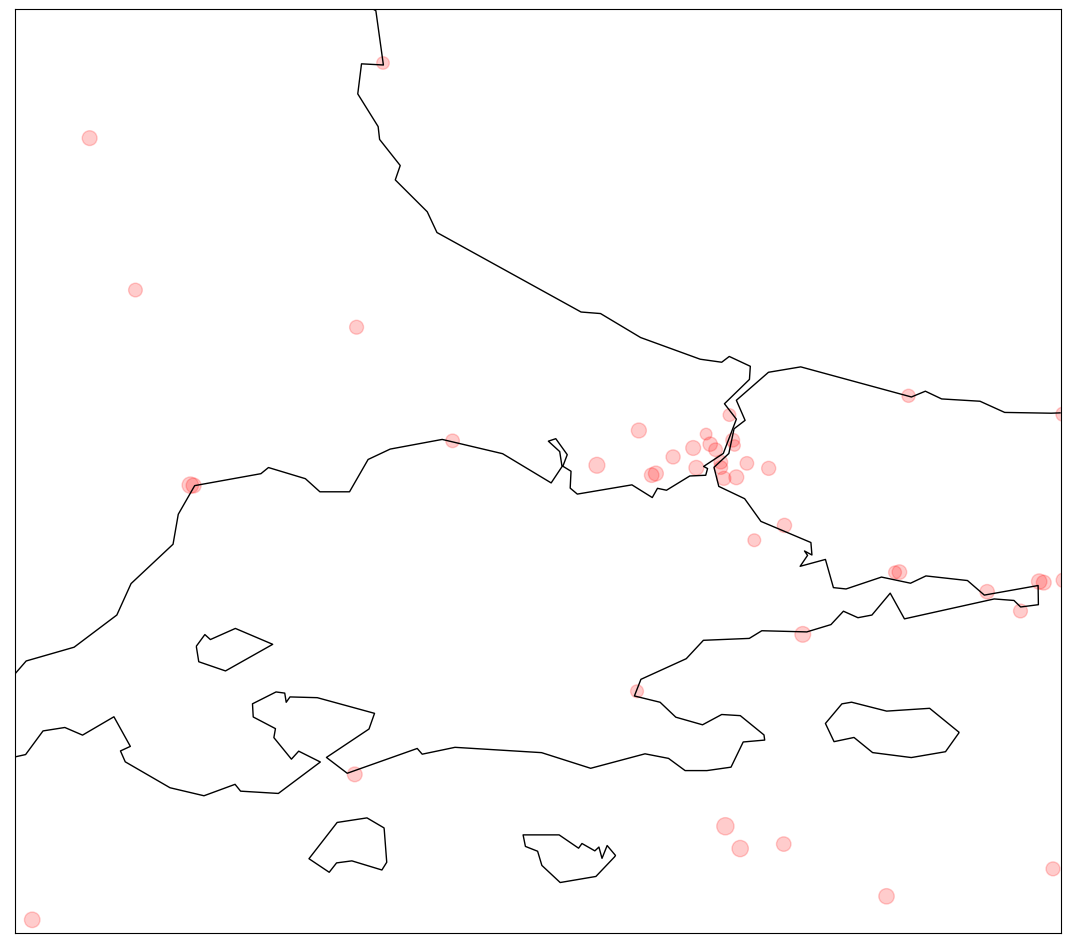

In [15]:
fig = plt.figure(figsize=(20,12))

m = Basemap(projection='merc',
           llcrnrlat = 40,
           urcrnrlat = 42,
           llcrnrlon = 27,
           urcrnrlon = 30,
           resolution='i')

m.drawcoastlines()

xs,ys = m(pollution['Longitude'].astype(float), pollution['Latitude'].astype(float))
sizes = pollution['AirPollutionLevel'].astype(float) + 60.0

m.scatter(xs, ys, s=sizes, c='red', alpha=0.2)

plt.show()

In [16]:
pollution[pollution['AQStationName']=='ISTANBUL-BESIKTAS']

5,Country,City,AirQualityStationEoICode,AQStationName,AirPollutant,AirPollutionLevel,UnitOfAirpollutionLevel,AirQualityStationType,AirQualityStationArea,Longitude,Latitude,Altitude
320,Turkey,NaN,TR341641,ISTANBUL-BESIKTAS,PM10,36.105251,ug/m3,Background,urban,29.01,41.05387999946805,99


# APIs where you would have to register and login

All of the data sources I quoted above are open. You don't neet to enter credentials to login and access the data. However, most commercial data vendors do ask you to register and login before you access their data. 

## NASDAQ Financial Data

Here is an example: [NASDAQ](https://data.nasdaq.com/). Nasdaq is world's first electronic exchange platform for buying and trading securities. It has an extensive data collection on markets. But you would need their specific python library, and also register at their site (you'll need and API key).

In [17]:
# !pip install nasdawdatalink
import nasdaqdatalink
nasdaqdatalink.read_key("/home/kaygun/.config/nasdaq/apikey")

In [18]:
data = nasdaqdatalink.get('CHRIS/CME_W1')
data

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1959-07-01,195.70,196.70,195.70,196.40,NaN,196.40,5828.0,25273.0
1959-07-02,196.30,197.40,196.30,197.10,NaN,197.10,4780.0,26524.0
1959-07-06,196.60,197.60,196.60,197.00,NaN,197.00,6591.0,27452.0
1959-07-07,197.30,197.50,196.70,197.10,NaN,197.10,5604.0,28749.0
1959-07-08,197.20,197.40,196.30,196.40,NaN,196.40,4538.0,30527.0
...,...,...,...,...,...,...,...,...
2021-06-23,653.25,668.25,653.25,662.25,10.25,661.25,35830.0,59819.0
2021-06-24,660.25,660.75,642.00,650.50,-10.00,651.25,27390.0,49474.0
2021-06-25,650.50,656.75,634.50,634.75,-14.25,637.00,35502.0,38808.0


<AxesSubplot:xlabel='Date'>

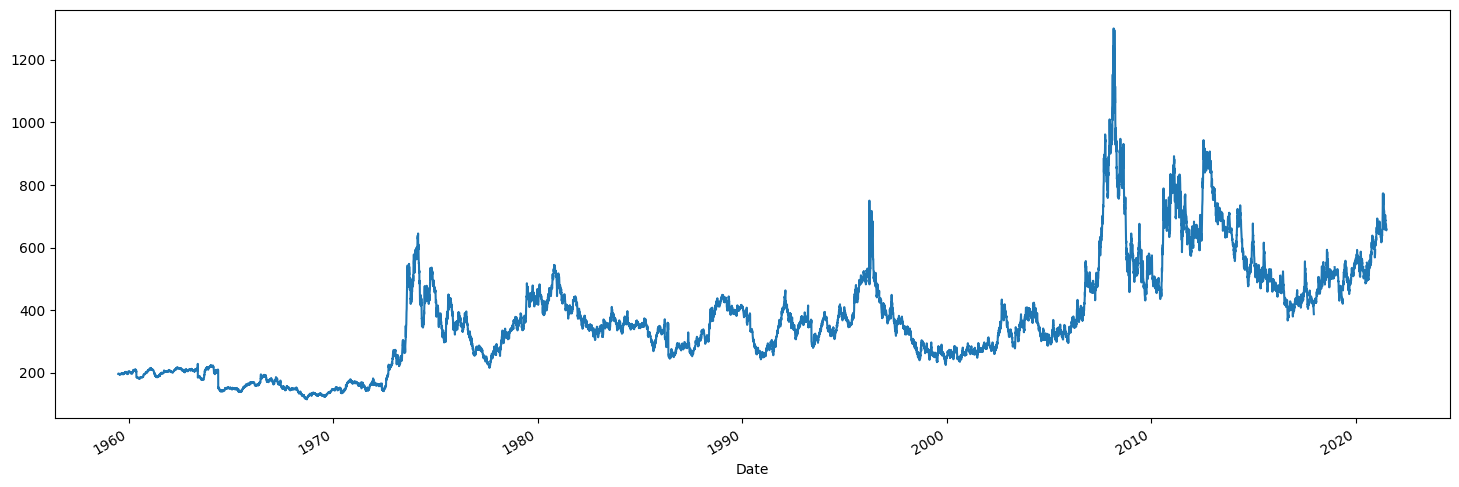

In [19]:
data['High'].plot(figsize=(18,6))

## Yahoo Finance Data API

In [20]:
import yfinance as yf

data = yf.download("AAPL", start="2000-01-01", end="2021-12-31")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,0.901228,0.918527,0.888393,0.917969,0.783791,163811200
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.853355,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.781409,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.792843,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.724232,767972800
...,...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.279999,175.553543,68356600
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.586868,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.551132,79144300


<AxesSubplot:xlabel='Date'>

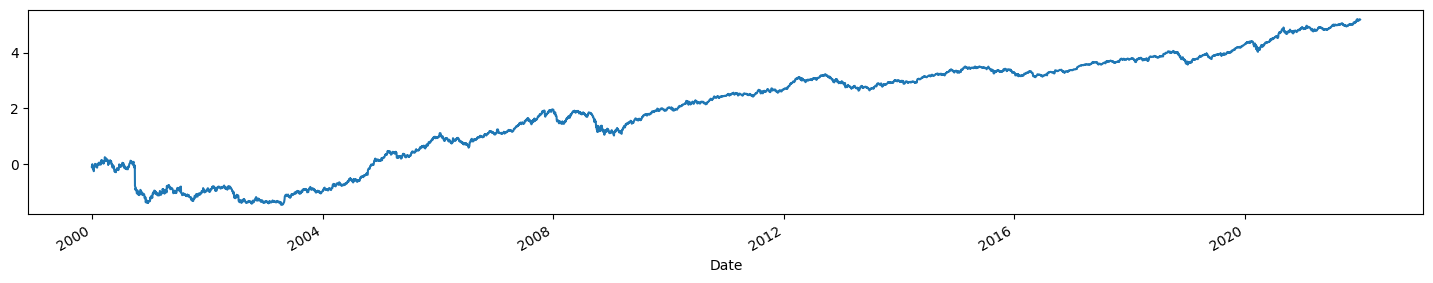

In [21]:
tmp = np.log(data['Close'])
tmp.plot(figsize=(18,3))

## Twitter Data

You can fetch data from [twitter](https://twitter.com) through their [API](https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api) and analyze it via python libraries. [Tweepy](https://www.tweepy.org/) is a popular choice, but you should definitely look around and find one that suits your needs.

Here is how I would install and import tweepy: Remember that "!pip install tweepy" should only be used once. Once you install it, you don't have to run that part ever again on your machine. But you must invoke "import tweepy" part every time you are going to use it.

In [22]:
#!pip install tweepy
import tweepy as tw
import json

I put all the necessary login details for the api into a single JSON file in my own directory. When you register at twitter you should replace 'apikey' file with your own with the following structure:

    {"API_key": "your api key",
     "API_secret_key": "your api secret key",
     "access_token": "your access token",
     "access_secret": "your access token secret"}

In [23]:
with open('/home/kaygun/.config/twitter/apikey') as file:
    keys = json.load(file)

This is how you would login:

In [24]:
auth = tw.OAuth1UserHandler(
   keys["API_key"], keys["API_secret_key"], keys["access_token"], keys["access_secret"]
)

api = tw.API(auth)

Let us collect some tweets from this month:

In [25]:
tweets = api.search_tweets(q='İTÜ', lang='tr', count=100)

and display 10 of them:


In [26]:
[x.text for x in tweets[:10]]

['RT @itu1773: İTÜ Eğitimde Mükemmeliyet Merkezi (İTÜ MEM) - Project Management Institute (@PMInstitute) Türkiye ile birlikte düzenlenen, PMI…',
 'İTÜ VE YEDİ YIL SAVAŞLARI İLE UKRAYNA-RUSYA SAVAŞININ NE İLİŞKİSİ VAR? https://t.co/lbbhIYD6iR',
 'İtü kızılkayalar kasiyeri sarışın kız bul beni',
 "RT @itu1773: 1797'de yayın faaliyetine başlayan ve 225 yıllık köklü tarihinde 5 bin civarında bilimsel eser basan İTÜ Yayınevi, yenilenen y…",
 'RT @ikoyuncu07: Mühendishane matbaasından bu yana 225 yıllık köklü geçmişe sahip İTÜ Yayınevi, yeniden yapılandırılarak hizmet etmeye başla…',
 "@odatv TUSAŞ, ASELSAN, ROKETSAN'da İHA'ları yapanlar ODTÜ, İTÜ, BOĞAZİÇİ'li Atatürkçü mühendisler.Okumamış tipler,… https://t.co/SsFGaKqBI0",
 "Edemem kardeş İTÜ'de okuyup da Bingöl Üniversitesinin kaynağından ders çalışmadan rahat edemem https://t.co/MJFm6odhpM",
 '@AlainBiraz Kafamda deli sorular İTÜ hukuk ? 😂 kuzuyu kucaklıyorum',
 '18-21 Ekim 2022 tarihlerinde İTÜ Havacılık ve Uzay Bilimleri Fakültesi TAV 

In [27]:
res = api.search_users('Atabey_Kaygun')

In [28]:
res[0]

User(_api=<tweepy.api.API object at 0x7fbafc509d50>, _json={'id': 17239073, 'id_str': '17239073', 'name': 'Atabey Kaygun', 'screen_name': 'Atabey_Kaygun', 'location': 'Istanbul', 'description': 'mathematician, batteries included.', 'url': 'https://t.co/T0G1VpGUdq', 'entities': {'url': {'urls': [{'url': 'https://t.co/T0G1VpGUdq', 'expanded_url': 'http://kaygun.tumblr.com/', 'display_url': 'kaygun.tumblr.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 1303, 'friends_count': 3561, 'listed_count': 110, 'created_at': 'Fri Nov 07 21:14:10 +0000 2008', 'favourites_count': 6252, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 22053, 'lang': None, 'status': {'created_at': 'Fri Oct 14 06:12:29 +0000 2022', 'id': 1580803710279905280, 'id_str': '1580803710279905280', 'text': 'RT @srush_nlp: Markup-to-Image Generation \n\n(w/ Yuntian Deng, Nori Kojima; https://t.co/V7lIsAkJqT; https://t.co/JvrQbGNCJA 